## Building a Web Application with Streamlit for Predicting Rain in Australia

This project focuses on building a web application that predicts whether rainfall will occur in a given region of Australia, with the goal of demonstrating the complete machine learning pipeline, from data preprocessing to prediction based on the entered data, and deploying the trained model using the Streamlit library.

In this part of the project, data loading, initial analysis, data preprocessing are performed.
Experiments with classification models are conducted to identify the most suitable model for the task at hand.

**Project Steps:**

1. Perform basic dataset EDA to identify an approach for data preprocessing, model and metric selection
1. Preprocess data.
1. Build models, tune hyperparameters.
1. Compare the models' results.
1. Save the best model for future usage in web application.
1. Build a web application for rain prediction.
1. Deploy the application.  

**Dataset:**
The Kaggle dataset comprises about 10 years of daily weather observations from numerous locations across Australia. 
You can download it here: 

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

**Project overview:**

The task is a **binary classification** problem, with **imbalanced classes** (one class is **3.46** times more frequent than the other). The dataset is heterogeneous, consisting of 16 numerical and 5 categorical features.

For the metrics in the rain prediction task, I have chosen **F1-Score** and **recall** to prioritize minimizing false negatives. I consider it more critical to avoid missing instances of rain, as this could lead to significant costs.

In [1]:
!pip install seaborn --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Import Libraries, Define Functions

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing and resampling
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, 
    roc_curve, auc, log_loss, precision_score, recall_score, 
    f1_score, confusion_matrix
)

# Saving and loading models
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from load_and_preprocess import load_model_components, preprocess_data

In [3]:
# Define predict and display metrics function
def predict_and_metrics(model, X, y, str):
    pred = model.predict(X)
    proba = model.predict_proba(X)[:,1]
    delimiter = '-------------------------------------\n'
    if str == 'Train':
        print(delimiter,type(model).__name__)
    print(f'{delimiter}Classification report for {str} set')
    print(classification_report(y, pred, digits=4))
    auroc = roc_auc_score(y, proba)
    precision = precision_score(y, pred)
    recall = recall_score (y, pred)
    f1 = f1_score(y, pred)
    print(f'AUROC for {str} set: {auroc:.6f}')
    return {'pred': pred, 'proba': proba, 'auroc': auroc, 'precision': precision, 'recall': recall, 'f1': f1} 

In [69]:
def update_results(results, metrics, str):
    
    results.loc[len(results)+1] = [
    str, 
    metrics['auroc'], 
    metrics['precision'], 
    metrics['recall'], 
    metrics['f1']
    ]
    return results

### 2. Data Loading and Basic EDA

In [5]:
# Load dataset
raw_df = pd.read_csv('data/weatherAUS.csv')

#### 2.1. General Overview

In [6]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
# Check general dataset information
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [8]:
numeric_cols = raw_df.select_dtypes(include = np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include = 'object').columns.tolist()

We can see that dataset has 22 features including 16 numeric and 5 categorical (we will not consider the `Date` column in the prediction). Some values in the dataset are missing. Let's examine the quantity of missing data in the dataset.

#### 2.2. Missing Values

In [9]:
# Check train dataset for null values
raw_df.isna().sum().apply(lambda x: format(x/raw_df.shape[0],'.2%'))

Date              0.00%
Location          0.00%
MinTemp           1.02%
MaxTemp           0.87%
Rainfall          2.24%
Evaporation      43.17%
Sunshine         48.01%
WindGustDir       7.10%
WindGustSpeed     7.06%
WindDir9am        7.26%
WindDir3pm        2.91%
WindSpeed9am      1.21%
WindSpeed3pm      2.11%
Humidity9am       1.82%
Humidity3pm       3.10%
Pressure9am      10.36%
Pressure3pm      10.33%
Cloud9am         38.42%
Cloud3pm         40.81%
Temp9am           1.21%
Temp3pm           2.48%
RainToday         2.24%
RainTomorrow      2.25%
dtype: object

We'll use the following approach for **handling missing values**:

1. Rows with missing values in the `RainToday` and `RainTomorrow` columns will be removed, as these are closely related to the target variable.
1. Missing values in numeric and categorical columns will be imputed using `SimpleImputer`

It is important to impute missing values because the `Random Forest` model does not accept datasets with missing values. It will be done at preprocessing stage.

In [10]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

#### 2.3. Class Balance

Now let's check if the dataset is balanced.

In [11]:
raw_df.RainTomorrow.value_counts()

RainTomorrow
No     109586
Yes     31201
Name: count, dtype: int64

In [12]:
class_imbalance = round(raw_df.RainTomorrow.value_counts()[0]/raw_df.RainTomorrow.value_counts()[1],2)
print(f'Class "No exceeds class "Yes" by {class_imbalance} times')

Class "No exceeds class "Yes" by 3.51 times


The dataset is imbalanced, with the `Yes` class significantly exceeding the `No` class. 
We will take class imbalance into account during model training.

#### 2.4. Correlation Analysis

In [13]:
raw_df['RainTomorrow'] = raw_df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
raw_df['RainTomorrow'].value_counts()

RainTomorrow
0    109586
1     31201
Name: count, dtype: int64

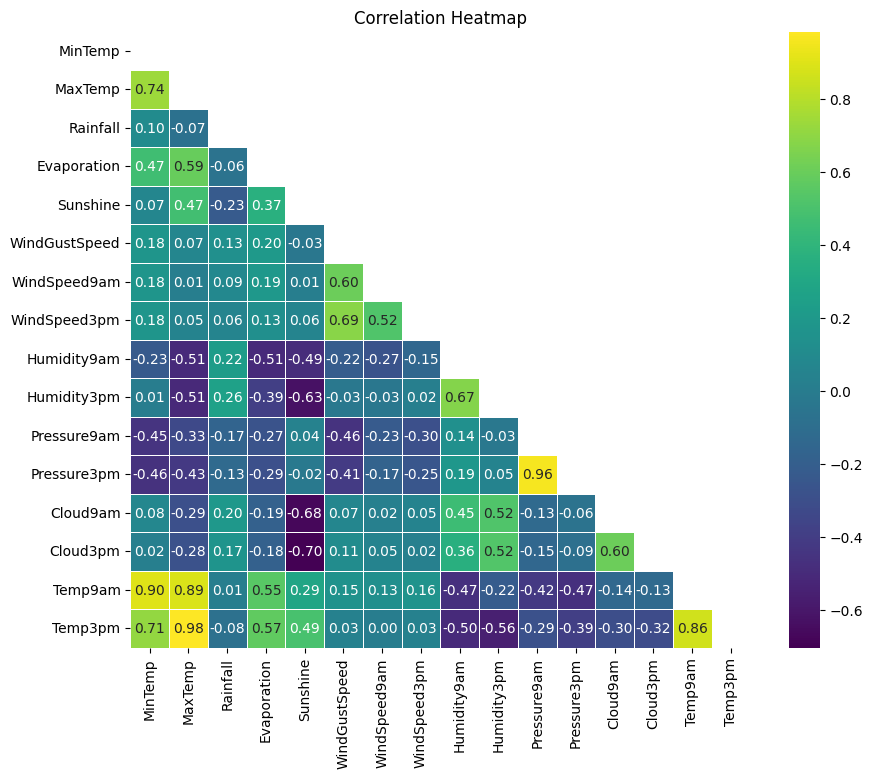

In [14]:
# Build correlation matrix
n = len(numeric_cols) 
mask = np.triu(np.ones(n))
corr_features = numeric_cols
corr_matrix = raw_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5, mask = mask)
plt.title("Correlation Heatmap")
plt.show()

Variables that have most significant effect on target column: `Rainfall`, `Sunshine`, `WindGustSpeed`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud9pm`.

#### 2.5. Chronological Distribution

Let's see how the data is distributed across the years.

In [15]:
pd.to_datetime(raw_df['Date']).dt.year.value_counts().sort_index()

Date
2007       61
2008     2229
2009    16514
2010    16191
2011    14983
2012    14894
2013    15935
2014    17181
2015    17089
2016    17341
2017     8369
Name: count, dtype: int64

The data is chronological in nature, so we will split it into training, validation, and test sets in chronological order as well:
1. before 2015 - train set,
2. 2015 - validation set,
3. 2016-2017 - test set.

#### 2.6. Metric Selection

For the primary metric in the rain prediction task, I have chosen **F1-Score** as it provides a good balance between precision and recall. However, I consider it more critical to avoid missing instances of rain, as this could lead to significant costs. Therefore, **recall** will be used as the secondary metric to prioritize minimizing false negatives.

### Conclusions

1. The task is a **binary classification** problem, with **imbalanced classes** (one class is **3.46** times more frequent than the other). The dataset is heterogeneous, consisting of 16 numerical and 5 categorical features.

2. Given these characteristics, we will use `Random Forest` and `XGBoost` models for the prediction. These models are well-suited for heterogeneous data  deliver high accuracy. Additionally,`XGBoost` is particularly effective in handling missing values.`Logistic Regression` will serve as the **baseline** model.

3. For the metrics in the rain prediction task, I have chosen **F1-Score** and **recall** to prioritize minimizing false negatives.

### 3. Data Preprocessing

Data preprocessing involves imputing missing values, scaling numerical features, and applying one-hot encoding to categorical variables to ensure the dataset is properly prepared for modeling.

In [16]:
# Preprocess raw data
delete_cols = ['Date']
data, model_comp= preprocess_data(raw_df, delete_cols)
categorical_cols = model_comp['categorical_cols']
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
X_train_xgb = data['X_train_xgb']
X_val_xgb = data['X_val_xgb']
X_test_xgb = data['X_test_xgb']
X_train_xgb[categorical_cols] = X_train_xgb[categorical_cols].astype('category')
X_val_xgb[categorical_cols] = X_val_xgb[categorical_cols].astype('category')
X_test_xgb[categorical_cols] = X_test_xgb[categorical_cols].astype('category')

### 4. Model Training. Baseline Experiment - Logistic Regression

In [80]:
# Define and train model
model_lr = LogisticRegression(random_state=42, solver  = 'liblinear').fit(X_train, y_train)
results_lr_train = predict_and_metrics(model_lr, X_train, y_train, 'Train')
results_lr_val = predict_and_metrics(model_lr, X_val, y_val, 'Validation')

-------------------------------------
 LogisticRegression
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.8738    0.9461    0.9085     76190
           1     0.7351    0.5225    0.6108     21798

    accuracy                         0.8519     97988
   macro avg     0.8045    0.7343    0.7597     97988
weighted avg     0.8430    0.8519    0.8423     97988

AUROC for Train set: 0.876636
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.8704    0.9585    0.9123     13511
           1     0.7462    0.4609    0.5698      3578

    accuracy                         0.8543     17089
   macro avg     0.8083    0.7097    0.7410     17089
weighted avg     0.8443    0.8543    0.8406     17089

AUROC for Validation set: 0.872397


Saving results of the **baseline** model.

In [81]:
results = pd.DataFrame({
    'model': ['LogisticRegression'],
    'auroc': [results_lr_val['auroc']],
    'precision': [results_lr_val['precision']],
    'recall': [results_lr_val['recall']],
    'f1': [results_lr_val['f1']]
}, index=[1])
results

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.5698


**Threshold Adjustment**

The model performs poorly in classifying `class 1` (**recall = 0.4508** on the validation set), meaning it frequently misses rainy days. To improve recall, the classification threshold can be lowered:

In [82]:
threshold = 0.25
pred_lr_val2 = [1 if (x>threshold) else 0 for x in results_lr_val['proba']]
results_lr_val['precision'] = precision_score(y_val, pred_lr_val2)
results_lr_val['recall'] = recall_score (y_val, pred_lr_val2)
results_lr_val['f1'] = f1_score(y_val, pred_lr_val2)
print (f'-------------------------------------\nClassification report for Validation set')
print(classification_report(y_val, pred_lr_val2, digits=4))

-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9159    0.8573    0.8856     13511
           1     0.5660    0.7026    0.6269      3578

    accuracy                         0.8249     17089
   macro avg     0.7409    0.7800    0.7563     17089
weighted avg     0.8426    0.8249    0.8315     17089



Through experimentation, a **threshold** of **0.25** was selected, resulting in an increase in **recall on the validation set** to **0.6976**. Additionally, the **F1-score** improved from **0.5618** to **0.6231**.

In [83]:
# Write results to dataframe for future model comparison
update_results(results, results_lr_val, 'LogisticRegression+Threshold')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933


### Conclusions

1. This **baseline** model demonstrates a high **ROC AUC** score (**0.872397**) but suffers from a low **F1 score** (**0.5698**). One of the key reasons for this discrepancy is class imbalance, which leads to poor performance in identifying the minority class (`class 1`) with a **recall** of only **0.460872**.

2. Model metrics can be improved: **recall on the validation set** to **0.6976**, **F1-score** to **0.6231** by adjusting the threshold level.

### 5. Model Training. Random Forest Classifier

The `Random Forest` model can work with imbalanced classes, but with a significant imbalance, it may become biased toward the majority class. To address this, we will use the following approaches:

1. **Class weighting**: Set the parameter class_weight='balanced' in RandomForestClassifier to automatically balance class weights based on their frequencies.
1. **Resampling**: Apply the resampling methods to balance the data before training.

#### 5.1. Random Forest Classifier with Class weighting

In [22]:
# Define and train Random Forest model with built-in class balancing
model_rf = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30, n_jobs=-1, random_state=42, class_weight = 'balanced')
model_rf.fit(X_train, y_train)

# Make predictions on train and validation sets
results_rf_train = predict_and_metrics(model_rf, X_train, y_train, 'Train')
results_rf_val = predict_and_metrics(model_rf, X_val, y_val, 'Validation')


-------------------------------------
 RandomForestClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.9190    0.7668    0.8360     76190
           1     0.4837    0.7637    0.5923     21798

    accuracy                         0.7661     97988
   macro avg     0.7013    0.7653    0.7141     97988
weighted avg     0.8222    0.7661    0.7818     97988

AUROC for Train set: 0.845596
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9144    0.7871    0.8460     13511
           1     0.4732    0.7219    0.5716      3578

    accuracy                         0.7735     17089
   macro avg     0.6938    0.7545    0.7088     17089
weighted avg     0.8221    0.7735    0.7886     17089

AUROC for Validation set: 0.837326


In [84]:
# Write results to dataframe for future model comparison
update_results(results, results_rf_val, 'RandomForest')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650


#### 5.2. Random Forest Classifier with Class Balancing

##### 5.2.1. RandomOverSampler

In [24]:
# Define and train RandomOverSample, resample data
ros = RandomOverSampler(random_state = 42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Define and train RF model
model_ros = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30, n_jobs=-1, random_state=42)
model_ros.fit(X_train_ros, y_train_ros)

# Make predictions and calculate metrics
results_ros_train = predict_and_metrics(model_ros, X_train_ros, y_train_ros, 'Train')
results_ros_val = predict_and_metrics(model_ros, X_val, y_val, 'Validation');

-------------------------------------
 RandomForestClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.7751    0.7542    0.7645     76190
           1     0.7607    0.7812    0.7708     76190

    accuracy                         0.7677    152380
   macro avg     0.7679    0.7677    0.7677    152380
weighted avg     0.7679    0.7677    0.7677    152380

AUROC for Train set: 0.850848
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9188    0.7740    0.8402     13511
           1     0.4650    0.7418    0.5716      3578

    accuracy                         0.7672     17089
   macro avg     0.6919    0.7579    0.7059     17089
weighted avg     0.8238    0.7672    0.7840     17089

AUROC for Validation set: 0.842482


##### 5.2.2. ADASYN Oversampling

In [25]:
# Define and train ADASYN algorithm, resample data
ad = ADASYN(random_state = 42, n_neighbors=7)
X_train_ad, y_train_ad = ad.fit_resample(X_train, y_train)

# Define and train RF model
model_ad = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30, n_jobs=-1, random_state=42)
model_ad.fit(X_train_ad, y_train_ad)

# Make predictions and calculate metrics
results_ad_train = predict_and_metrics(model_ad, X_train_ad, y_train_ad, 'Train')
results_ad_val = predict_and_metrics(model_ad, X_val, y_val, 'Validation');

-------------------------------------
 RandomForestClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.7871    0.7591    0.7729     76190
           1     0.7635    0.7911    0.7771     74894

    accuracy                         0.7750    151084
   macro avg     0.7753    0.7751    0.7750    151084
weighted avg     0.7754    0.7750    0.7749    151084

AUROC for Train set: 0.857983
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9139    0.7848    0.8445     13511
           1     0.4701    0.7208    0.5691      3578

    accuracy                         0.7714     17089
   macro avg     0.6920    0.7528    0.7068     17089
weighted avg     0.8210    0.7714    0.7868     17089

AUROC for Validation set: 0.837785


##### 5.2.3. RandomUnderSampler

In [26]:
# Define and train RandomUnderSample, resample data
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Define and train RF model
model_rus = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30, n_jobs=-1, random_state=42)
model_rus.fit(X_train_rus, y_train_rus)

# Make predictions and calculate metrics
results_rus_train = predict_and_metrics(model_rus, X_train_rus, y_train_rus, 'Train')
results_rus_val = predict_and_metrics(model_rus, X_val, y_val, 'Validation');

-------------------------------------
 RandomForestClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.7749    0.7625    0.7687     21798
           1     0.7663    0.7785    0.7723     21798

    accuracy                         0.7705     43596
   macro avg     0.7706    0.7705    0.7705     43596
weighted avg     0.7706    0.7705    0.7705     43596

AUROC for Train set: 0.852272
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9184    0.7785    0.8427     13511
           1     0.4690    0.7390    0.5738      3578

    accuracy                         0.7702     17089
   macro avg     0.6937    0.7587    0.7083     17089
weighted avg     0.8243    0.7702    0.7864     17089

AUROC for Validation set: 0.840409


In [85]:
# Write results to dataframe for future model comparison
update_results(results, results_ros_val, 'RandomForest+ROS')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650
4,RandomForest+ROS,0.842482,0.464961,0.741755,0.571613


The usage of `RandomOverSampler` resulted in a slight improvement in **ROCAUC** (from **0.837326** to **0.842482**), indicating a better ability of the model to distinguish between classes. However, the impact on **precision** and **recall** was minimal: **precision** slightly **decreased** (from **0.473164 to 0.464961**), and **recall** slightly increased (from 0.721912 to **0.741755**). The **F1-score** remained virtually unchanged. This suggests that while RandomOverSampler improved slightly the model's ability to differentiate between classes.

### Conclusions

In our case, with a class ratio of **3.46:1**, `RandomOverSampler` will be the best choice as it helps balance the classes without losing important information from `class 0`.

The use of methods related to creating synthetic points (such as `ADASYN` or `SMOTE`) is less desirable, as a large amount of data imputation has been applied, and generating synthetic points could significantly distort the data.

#### 5.3. Random Forest Classifier Hyperparameter Tuning

Let's optimize hyperparameters.

In [28]:
# Set the parameter grid, run hyperparameter tuning
param_grid = {
    'n_estimators': [20, 25, 30 ], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
gs = GridSearchCV(model_ros, param_grid, scoring = 'roc_auc', cv = 4, n_jobs = -1, verbose=3)
gs.fit(X_train_ros, y_train_ros)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_leaf_nodes=30,
                                              n_estimators=20, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 25, 30]},
             scoring='roc_auc', verbose=3)

In [29]:
# Make predictions and calculate metrics for best found estimator 
model_gs = gs.best_estimator_
results_gs_train = predict_and_metrics(model_gs, X_train_ros, y_train_ros, 'Train')
results_gs_val = predict_and_metrics(model_gs, X_val, y_val, 'Validation')


-------------------------------------
 RandomForestClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.7722    0.7665    0.7694     76190
           1     0.7682    0.7739    0.7710     76190

    accuracy                         0.7702    152380
   macro avg     0.7702    0.7702    0.7702    152380
weighted avg     0.7702    0.7702    0.7702    152380

AUROC for Train set: 0.852801
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9169    0.7890    0.8482     13511
           1     0.4781    0.7300    0.5778      3578

    accuracy                         0.7766     17089
   macro avg     0.6975    0.7595    0.7130     17089
weighted avg     0.8250    0.7766    0.7915     17089

AUROC for Validation set: 0.844412


In [86]:
# Write results to dataframe for future model comparison
update_results(results, results_gs_val, 'RandomForest+GridSearchCV')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650
4,RandomForest+ROS,0.842482,0.464961,0.741755,0.571613
5,RandomForest+GridSearchCV,0.844412,0.478126,0.730017,0.577812


### Conclusions

Applying `GridSearchCV` didn't have a significant effect on model performance.

### 6. Model Training. XGBoost model

The `XGBoost` model handles missing values and categorical data well, so the original data will be used for training and validation without preprocessing.

In [31]:
# Define xgb classifier
model_xgb = XGBClassifier(
    n_estimators = 10,
    max_depth = 3,
    device = 'cpu',
    verbosity = 2,
    eval_metric = 'logloss', 
    colsample_bytree = 0.7,
    enable_categorical = True,
    random_state=42
)

model_xgb.fit(X_train_xgb, y_train)

# Make predictions and calculate metrics
results_xgb_train = predict_and_metrics(model_xgb, X_train_xgb, y_train, 'Train')
results_xgb_val = predict_and_metrics(model_xgb, X_val_xgb, y_val, 'Validation');

-------------------------------------
 XGBClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.8628    0.9602    0.9089     76190
           1     0.7704    0.4661    0.5808     21798

    accuracy                         0.8503     97988
   macro avg     0.8166    0.7132    0.7449     97988
weighted avg     0.8422    0.8503    0.8359     97988

AUROC for Train set: 0.872821
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.8633    0.9654    0.9115     13511
           1     0.7638    0.4229    0.5443      3578

    accuracy                         0.8518     17089
   macro avg     0.8135    0.6941    0.7279     17089
weighted avg     0.8425    0.8518    0.8346     17089

AUROC for Validation set: 0.865837


In [87]:
# Write results to dataframe for future model comparison
update_results(results, results_xgb_val, 'XGBoost')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650
4,RandomForest+ROS,0.842482,0.464961,0.741755,0.571613
5,RandomForest+GridSearchCV,0.844412,0.478126,0.730017,0.577812
6,XGBoost,0.865837,0.763756,0.422862,0.544343


Hyperparameter tuning:

In [88]:
# Define objective function
def objective(params):
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        missing=np.nan,
        device='cpu',
        early_stopping_rounds=10,
        random_state=42
    )

    clf.fit(
        X_train_xgb,
        y_train,
        eval_set=[(X_val_xgb, y_val)],
        verbose=False)
    pred = clf.predict(X_val_xgb)
    proba = clf.predict_proba(X_val_xgb)[:,1]
    f1 = f1_score(y_val, pred)
    #auc = roc_auc_score(y_val, proba)

    return {'loss': -f1, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 400, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'gamma': hp.uniform('gamma', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.8, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.8, 1)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

100%|███████| 20/20 [01:01<00:00,  3.07s/trial, best loss: -0.6277833167165171]


In [89]:
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
model_ho = XGBClassifier(**best, enable_categorical=True, missing=np.nan, device='cpu')
best

{'colsample_bytree': np.float64(0.9654050850067806),
 'gamma': np.float64(0.6723808575580941),
 'learning_rate': np.float64(0.03325066215280847),
 'max_depth': 10,
 'min_child_weight': 4,
 'n_estimators': 250,
 'reg_alpha': np.float64(0.8127925534115487),
 'reg_lambda': np.float64(0.9603114388206491),
 'subsample': np.float64(0.6505202669084695)}

In [90]:
model_ho.fit(X_train_xgb, y_train)

# Make predictions and calculate metrics
results_ho_train = predict_and_metrics(model_ho, X_train_xgb, y_train, 'Train')
results_ho_val = predict_and_metrics(model_ho, X_val_xgb, y_val, 'Validation');

-------------------------------------
 XGBClassifier
-------------------------------------
Classification report for Train set
              precision    recall  f1-score   support

           0     0.9349    0.9841    0.9589     76190
           1     0.9319    0.7606    0.8376     21798

    accuracy                         0.9344     97988
   macro avg     0.9334    0.8723    0.8982     97988
weighted avg     0.9342    0.9344    0.9319     97988

AUROC for Train set: 0.978250
-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.8835    0.9594    0.9198     13511
           1     0.7729    0.5221    0.6232      3578

    accuracy                         0.8678     17089
   macro avg     0.8282    0.7407    0.7715     17089
weighted avg     0.8603    0.8678    0.8577     17089

AUROC for Validation set: 0.898868


In [91]:
# Write results to dataframe for future model comparison
update_results(results, results_ho_val, 'XGBoost+Hyperopt')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650
4,RandomForest+ROS,0.842482,0.464961,0.741755,0.571613
5,RandomForest+GridSearchCV,0.844412,0.478126,0.730017,0.577812
6,XGBoost,0.865837,0.763756,0.422862,0.544343
7,XGBoost+Hyperopt,0.898868,0.772859,0.522079,0.623186


Now we'll experimentally adjust the threshold to improve the detection of the minority class and balance **F1** and **recall** scores.

In [92]:
threshold = 0.2
pred_ho_val2 = [1 if (x>threshold) else 0 for x in results_ho_val['proba']]
results_ho_val['precision'] = precision_score(y_val, pred_ho_val2)
results_ho_val['recall'] = recall_score (y_val, pred_ho_val2)
results_ho_val['f1'] = f1_score(y_val, pred_ho_val2)
print (f'-------------------------------------\nClassification report for Validation set')
print(classification_report(y_val, pred_ho_val2, digits=4))

-------------------------------------
Classification report for Validation set
              precision    recall  f1-score   support

           0     0.9346    0.8395    0.8845     13511
           1     0.5621    0.7781    0.6527      3578

    accuracy                         0.8266     17089
   macro avg     0.7483    0.8088    0.7686     17089
weighted avg     0.8566    0.8266    0.8359     17089



In [93]:
# Write results to dataframe for future model comparison
update_results(results, results_ho_val, 'XGBoost+Hyperopt+Threshold')

,model,auroc,precision,recall,f1
1,LogisticRegression,0.872397,0.746154,0.460872,0.569800
2,LogisticRegression+Threshold,0.872397,0.565961,0.702627,0.626933
3,RandomForest,0.837326,0.473164,0.721912,0.571650
4,RandomForest+ROS,0.842482,0.464961,0.741755,0.571613
5,RandomForest+GridSearchCV,0.844412,0.478126,0.730017,0.577812
6,XGBoost,0.865837,0.763756,0.422862,0.544343
7,XGBoost+Hyperopt,0.898868,0.772859,0.522079,0.623186
8,XGBoost+Hyperopt+Threshold,0.898868,0.562084,0.778088,0.652678


### Conclusions

The model `XGBoost` with `Hyperopt` optimization and threshold adjustment demonstrated notable improvements over `baseline` (`LogisticRegression`). `AUROC` increased from `0.872397` to `0.898868`, showing a better ability to distinguish between classes. `Recall` improved significantly from `0.460872` to `0.778088`, indicating a much better performance in identifying the minority class. Additionally, the `F1-score` rose from `0.569800` to `0.652678`, reflecting a more balanced performance between precision and recall. 

These results suggest that the use of `XGBoost` with `Hyperopt` optimization and threshold adjustment significantly enhanced the model's ability to correctly classify the minority class while maintaining a good overall performance.

In [94]:
# Save model with new trained estimator
trained_model = {
    'model': model_ho,
    'num_imputer': model_comp['num_imputer'],
    'cat_imputer': model_comp['cat_imputer'],
    'scaler': model_comp['scaler'],
    'encoder': model_comp['encoder'],
    'input_cols': model_comp['input_cols'],
    'target_col': model_comp['target_col'],
    'numeric_cols': model_comp['numeric_cols'],
    'categorical_cols': model_comp['categorical_cols'],
    'encoded_cols': model_comp['encoded_cols']
}
joblib.dump(trained_model, "models/trained_model.joblib")

['models/trained_model.joblib']